In [1]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 3
subj_base = 'pipr-90s-sub-003_ses-01_dat-20230714' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

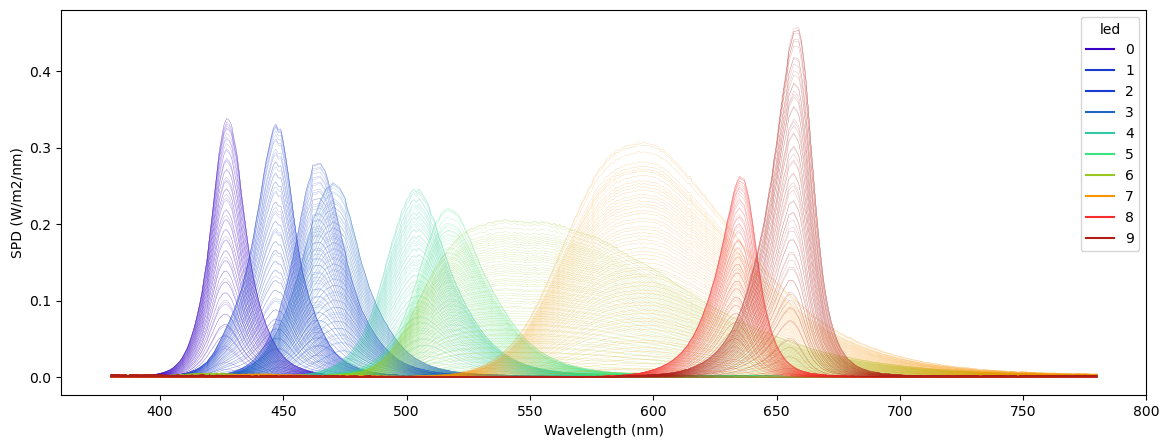

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


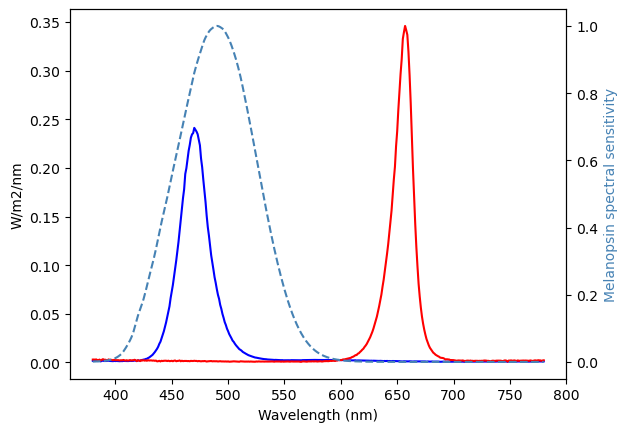

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [8]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: n


Please enter subject ID: 003
> Grabbing 540 seconds of pupil.1.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 163281.778586
> Waiting for a light to stamp...
> Light stamped on frame.world at 163373.374142
> Waiting for a light to stamp...
> Light stamped on frame.world at 163464.797657
> Waiting for a light to stamp...
> Light stamped on frame.world at 163556.27039299998
> Waiting for a light to stamp...
> Light stamped on frame.world at 163647.695539
> Waiting for a light to stamp...
> Light stamped on frame.world at 163739.07897099998
> PupilGrabber done grabbing 540 seconds of pupil.1.3d


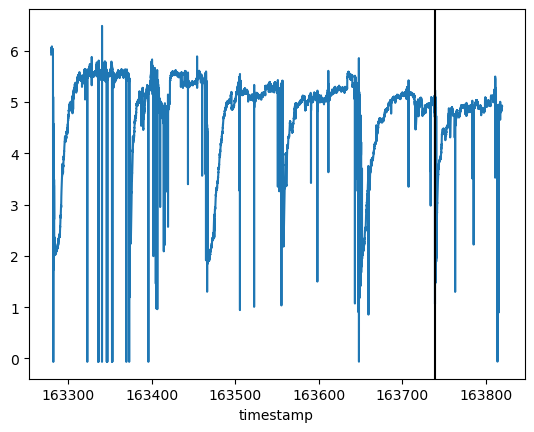

In [9]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials # appropriate offset to account for stim duration + sleeps (removed + 30)


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [10]:
# display data from pandas table
data

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
163279.706877,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2834205045239708, 0.8917762471511038]",60.746402,0.881473,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.746899343974204, -7.91216812246...",5.926915,"{'center': [54.41673686860239, 20.778960546988...","[54.41673686860239, 20.778960546988074]",1.0,1.898553,-2.128515
163279.725319,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2836115425129489, 0.8919474386109975]",61.250175,0.824318,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.744275865921645, -7.91219975252...",5.979002,"{'center': [54.45341616248619, 20.746091786688...","[54.45341616248619, 20.74609178668848]",1.0,1.898556,-2.128202
163279.735465,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2835639553146226, 0.8915755169395714]",61.024514,0.862500,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.736458698896463, -7.90520686910...",5.955895,"{'center': [54.44427942040754, 20.817500747602...","[54.44427942040754, 20.817500747602296]",1.0,1.897845,-2.127116
163279.758306,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2834540437032765, 0.8915564514361686]",61.214257,0.893558,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.737318359935353, -7.90564069767...",5.975739,"{'center': [54.42317639102909, 20.821161324255...","[54.42317639102909, 20.821161324255627]",1.0,1.897889,-2.127228
163279.780713,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2831108533314237, 0.8911446213587663]",61.130740,0.866881,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.739447049589545, -7.88793272974...",5.967622,"{'center': [54.357283839633354, 20.90023269911...","[54.357283839633354, 20.900232699116884]",1.0,1.896090,-2.127104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163819.612010,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3178039861131024, 0.7691459946416948]",58.133392,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.264307040390453, -4.81545432638...",4.920016,"{'center': [61.018365333715664, 44.32396902879...","[61.018365333715664, 44.32396902879461]",1.0,1.702938,-2.035710
163819.633837,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.317602202316289, 0.7696479012074503]",58.269819,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.2774303285690727, -4.8224325909...",4.931831,"{'center': [60.97962284472749, 44.227602968169...","[60.97962284472749, 44.22760296816954]",1.0,1.703615,-2.037182
163819.662647,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3171421127278029, 0.7703357844813391]",58.216411,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.3008937320189795, -4.8364561661...",4.927161,"{'center': [60.89128564373816, 44.095529379582...","[60.89128564373816, 44.09552937958289]",1.0,1.704977,-2.039826


In [11]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '.csv')

**DATA PROCESSING BEGINS BELOW**

In [12]:
samples = data
samples

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
163279.706877,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2834205045239708, 0.8917762471511038]",60.746402,0.881473,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.746899343974204, -7.91216812246...",5.926915,"{'center': [54.41673686860239, 20.778960546988...","[54.41673686860239, 20.778960546988074]",1.0,1.898553,-2.128515
163279.725319,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2836115425129489, 0.8919474386109975]",61.250175,0.824318,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.744275865921645, -7.91219975252...",5.979002,"{'center': [54.45341616248619, 20.746091786688...","[54.45341616248619, 20.74609178668848]",1.0,1.898556,-2.128202
163279.735465,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2835639553146226, 0.8915755169395714]",61.024514,0.862500,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.736458698896463, -7.90520686910...",5.955895,"{'center': [54.44427942040754, 20.817500747602...","[54.44427942040754, 20.817500747602296]",1.0,1.897845,-2.127116
163279.758306,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2834540437032765, 0.8915564514361686]",61.214257,0.893558,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.737318359935353, -7.90564069767...",5.975739,"{'center': [54.42317639102909, 20.821161324255...","[54.42317639102909, 20.821161324255627]",1.0,1.897889,-2.127228
163279.780713,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2831108533314237, 0.8911446213587663]",61.130740,0.866881,"{'center': [0.46046009323181014, -4.5666826579...","{'center': [99.08483206054724, 63.870866401996...","{'center': [-4.739447049589545, -7.88793272974...",5.967622,"{'center': [54.357283839633354, 20.90023269911...","[54.357283839633354, 20.900232699116884]",1.0,1.896090,-2.127104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163819.612010,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3178039861131024, 0.7691459946416948]",58.133392,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.264307040390453, -4.81545432638...",4.920016,"{'center': [61.018365333715664, 44.32396902879...","[61.018365333715664, 44.32396902879461]",1.0,1.702938,-2.035710
163819.633837,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.317602202316289, 0.7696479012074503]",58.269819,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.2774303285690727, -4.8224325909...",4.931831,"{'center': [60.97962284472749, 44.227602968169...","[60.97962284472749, 44.22760296816954]",1.0,1.703615,-2.037182
163819.662647,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3171421127278029, 0.7703357844813391]",58.216411,1.000000,"{'center': [1.354421552098199, -3.446194829224...","{'center': [106.3274979732012, 69.329266309348...","{'center': [-3.3008937320189795, -4.8364561661...",4.927161,"{'center': [60.89128564373816, 44.095529379582...","[60.89128564373816, 44.09552937958289]",1.0,1.704977,-2.039826


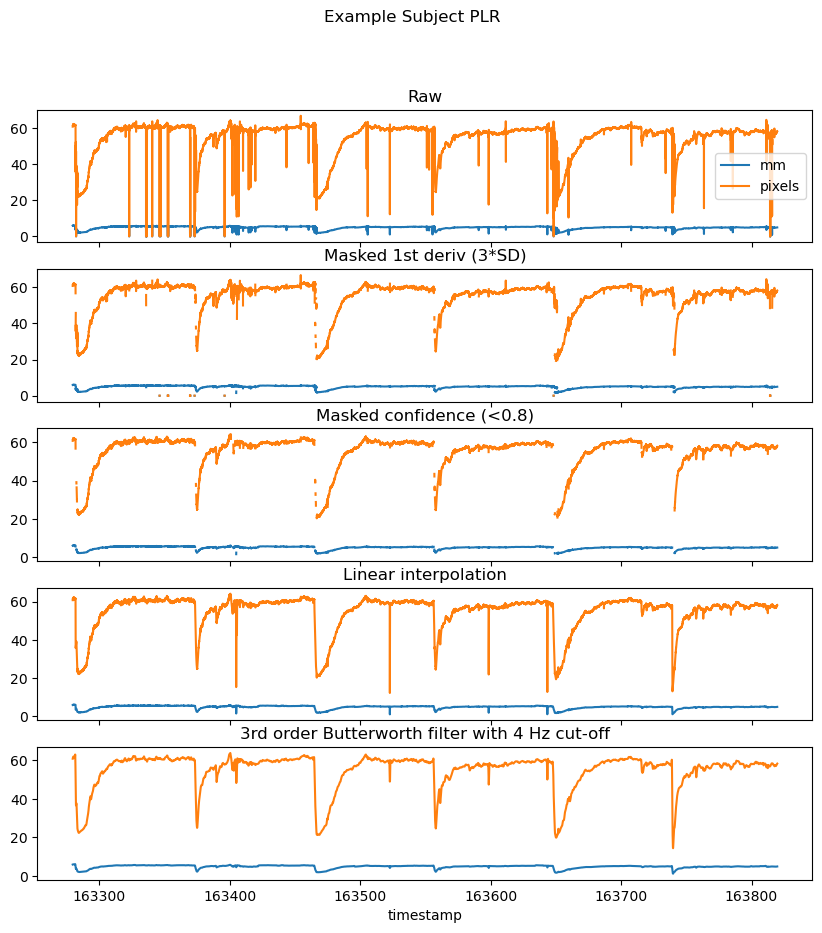

In [13]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [14]:
# export butterworth processed sample data (?)
samples.to_csv(path_base + subj_base + '-butterworth.csv') # raw data
# can stop here if necessary

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr = pd.read_csv(path_base + subj_base + '.csv')

# Print header names
print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps = df_pipr["timestamp"]
# Extract the column with header "diameter"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi'],
      dtype='object')


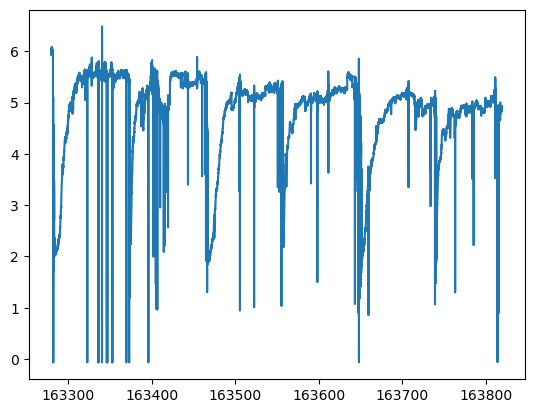

In [18]:
fig = plt.figure()
plt.plot(timestamps, diam_3d)

This is copied from the output of cell 11
> Light stamped on frame.world at 163281.778586
> Waiting for a light to stamp...
> Light stamped on frame.world at 163373.374142
> Waiting for a light to stamp...
> Light stamped on frame.world at 163464.797657
> Waiting for a light to stamp...
> Light stamped on frame.world at 163556.27039299998
> Waiting for a light to stamp...
> Light stamped on frame.world at 163647.695539
> Waiting for a light to stamp...
> Light stamped on frame.world at 163739.07897099998

**Edit Cell Below with Timestamps**

In [19]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 163281.778586)[0][-1]
stamp2 = np.where(timestamps <= 163373.374142)[0][-1]
stamp3 = np.where(timestamps <= 163464.797657)[0][-1]
stamp4 = np.where(timestamps <= 163556.27039299998)[0][-1]
stamp5 = np.where(timestamps <= 163647.695539)[0][-1]
stamp6 = np.where(timestamps <= 163739.07897099998)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[98, 4477, 8599, 12783, 17018, 21133]

In [20]:
from pyplr import utils
from copy import deepcopy

In [21]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,163279.706877,0.881473,1,60.746402,5.926915
1,163279.725319,0.824318,1,61.250175,5.979002
2,163279.735465,0.862500,1,61.024514,5.955895
3,163279.758306,0.893558,1,61.214257,5.975739
4,163279.780713,0.866881,1,61.130740,5.967622
...,...,...,...,...,...
24794,163819.612010,1.000000,1,58.133392,4.920016
24795,163819.633837,1.000000,1,58.269819,4.931831
24796,163819.662647,1.000000,1,58.216411,4.927161
24797,163819.684875,1.000000,1,58.233095,4.928107


**Extract ranges from samples based on event timing and sample count**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [22]:
samples = df_data
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [23]:
range_idxs

array([   38,  4417,  8539, 12723, 16958, 21073], dtype=int64)

In [24]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_14248\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [25]:
df.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data**

In [26]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_14248\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      163280.461332    0.892528   1  61.661696     6.019363        38   
      1      163280.481839    0.898709   1  62.162302     6.070900        39   
      2      163280.502625    0.906977   1  61.964482     6.052378        40   
      3      163280.518213    0.902831   1  61.928918     6.050215        41   
      4      163280.538273    0.877972   1  61.903179     6.047780        42   
...                    ...         ...  ..        ...          ...       ...   
5     3595   163816.781114    0.993368   1  57.327709     4.862770     24668   
      3596   163816.805012    1.000000   1  57.384594     4.867191     24669   
      3597   163816.829372    1.000000   1  57.338790     4.862280     24670   
      3598   163816.847381    0.941975   1  57.437493     4.869693     24671   
      3599   163816.869411    0.965942   1  57.474095     4.871925     24672   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.069439     0.027273  
      1            0.926228     0.839353  
      2            0.618302     0.518451  
      3            0.582350     0.460759  
      4            0.541871     0.419006  
...                     ...          ...  
5     3595        -1.867242    -0.925990  
      3596        -1.778028    -0.827681  
      3597        -1.877140    -0.906841  
      3598        -1.727550    -0.736262  
      3599        -1.682497    -0.673005  

[21600 rows x 8 columns]

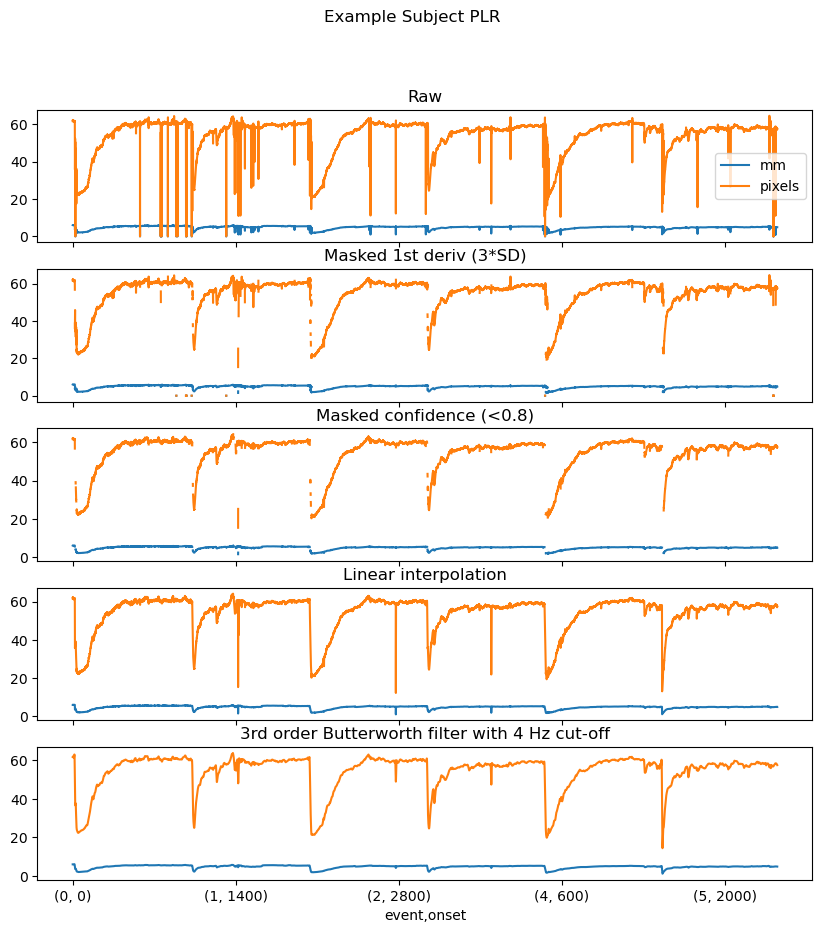

In [27]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples = df

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [28]:
samples # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      163280.461332    0.892528   1  61.661919     6.019517        38   
      1      163280.481839    0.898709   1  61.710202     6.024598        39   
      2      163280.502625    0.906977   1  61.757111     6.029521        40   
      3      163280.518213    0.902831   1  61.801440     6.034153        41   
      4      163280.538273    0.877972   1  61.842109     6.038374        42   
...                    ...         ...  ..        ...          ...       ...   
5     3595   163816.781114    0.993368   1  57.492153     4.871474     24668   
      3596   163816.805012    1.000000   1  57.479088     4.870762     24669   
      3597   163816.829372    1.000000   1  57.469062     4.870281     24670   
      3598   163816.847381    0.941975   1  57.461749     4.869998     24671   
      3599   163816.869411    0.965942   1  57.456735     4.869874     24672   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            0.069439     0.027273             0  
      1            0.926228     0.839353             0  
      2            0.618302     0.518451             0  
      3            0.582350     0.460759             0  
      4            0.541871     0.419006             0  
...                     ...          ...           ...  
5     3595        -1.867242    -0.925990             0  
      3596        -1.778028    -0.827681             0  
      3597        -1.877140    -0.906841             0  
      3598        -1.727550    -0.736262             0  
      3599        -1.682497    -0.673005             0  

[21600 rows x 9 columns]

In [29]:
df

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      163280.461332    0.892528   1  61.661696     6.019363        38   
      1      163280.481839    0.898709   1  62.162302     6.070900        39   
      2      163280.502625    0.906977   1  61.964482     6.052378        40   
      3      163280.518213    0.902831   1  61.928918     6.050215        41   
      4      163280.538273    0.877972   1  61.903179     6.047780        42   
...                    ...         ...  ..        ...          ...       ...   
5     3595   163816.781114    0.993368   1  57.327709     4.862770     24668   
      3596   163816.805012    1.000000   1  57.384594     4.867191     24669   
      3597   163816.829372    1.000000   1  57.338790     4.862280     24670   
      3598   163816.847381    0.941975   1  57.437493     4.869693     24671   
      3599   163816.869411    0.965942   1  57.474095     4.871925     24672   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.069439     0.027273  
      1            0.926228     0.839353  
      2            0.618302     0.518451  
      3            0.582350     0.460759  
      4            0.541871     0.419006  
...                     ...          ...  
5     3595        -1.867242    -0.925990  
      3596        -1.778028    -0.827681  
      3597        -1.877140    -0.906841  
      3598        -1.727550    -0.736262  
      3599        -1.682497    -0.673005  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [30]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df.index = df.index.set_levels(
    levels=new_onset, level='onset')

In [31]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc'],
      dtype='object')

In [32]:
df["colour"] = ""

In [33]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc', 'colour'],
      dtype='object')

In [34]:
for (event, onset) in df.index:
    if event%2==1:
        df["colour"][event,onset] = "red"
    else:
        df["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_14248\884742854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_14248\884742854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 1')

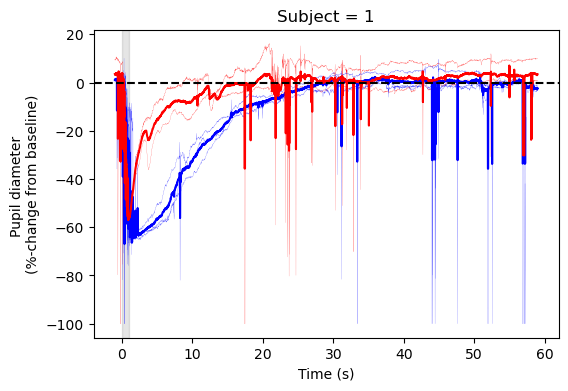

In [35]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs = (df.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

In [36]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '.png')

In [37]:
df # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   163280.461332    0.892528   1  61.661696     6.019363   
      -0.983333   163280.481839    0.898709   1  62.162302     6.070900   
      -0.966667   163280.502625    0.906977   1  61.964482     6.052378   
      -0.950000   163280.518213    0.902831   1  61.928918     6.050215   
      -0.933333   163280.538273    0.877972   1  61.903179     6.047780   
...                         ...         ...  ..        ...          ...   
5      58.916667  163816.781114    0.993368   1  57.327709     4.862770   
       58.933333  163816.805012    1.000000   1  57.384594     4.867191   
       58.950000  163816.829372    1.000000   1  57.338790     4.862280   
       58.966667  163816.847381    0.941975   1  57.437493     4.869693   
       58.983333  163816.869411    0.965942   1  57.474095     4.871925   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         38        0.069439     0.027273   blue  
      -0.983333         39        0.926228     0.839353   blue  
      -0.966667         40        0.618302     0.518451   blue  
      -0.950000         41        0.582350     0.460759   blue  
      -0.933333         42        0.541871     0.419006   blue  
...                    ...             ...          ...    ...  
5      58.916667     24668       -1.867242    -0.925990    red  
       58.933333     24669       -1.778028    -0.827681    red  
       58.950000     24670       -1.877140    -0.906841    red  
       58.966667     24671       -1.727550    -0.736262    red  
       58.983333     24672       -1.682497    -0.673005    red  

[21600 rows x 9 columns]

In [38]:
df.to_csv(path_base + subj_base + '-processed.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

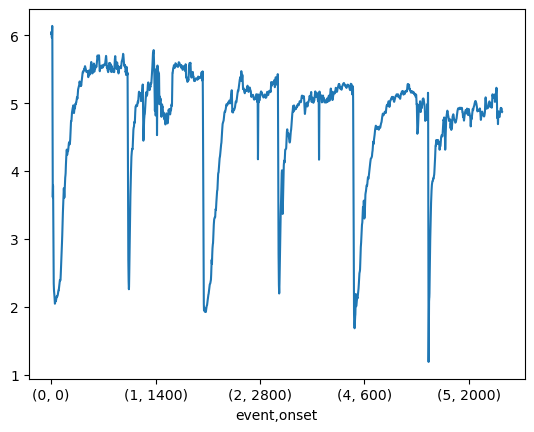

In [39]:
samples["diameter_3d"].plot()

**Compute the pupillary light response:**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**PIPR**

In [44]:
avgs.to_csv(path_base + subj_base + '-average-pipr.csv') # processed data with adjusted onset indices (time in seconds)

In [40]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
avgs.loc[avgs["onset"] == pipr_time]

,colour,onset,event,timestamp,confidence,id,diameter,diameter_3d,orig_idx,diameter_3d_pc,diameter_pc
480,blue,7.0,2.0,163474.492349,1.000000,1.0,31.613767,2.818875,8991.666667,-48.379044,-47.100138
4080,red,7.0,3.0,163565.789451,0.963156,1.0,52.058691,4.637290,13217.666667,-8.548832,-9.040815


In [41]:
blue_d_pipr = avgs["diameter_3d"][480]
red_d_pipr = avgs["diameter_3d"][4080]
blue_d_pipr_pc = avgs["diameter_3d_pc"][480]
red_d_pipr_pc = avgs["diameter_3d_pc"][4080]
pipr_diff = red_d_pipr - blue_d_pipr
pipr_pc_diff = red_d_pipr_pc - blue_d_pipr_pc

In [42]:
pipr_diff

1.8184149042390834

In [43]:
pipr_pc_diff

39.830211670298155